System Model
---------------

\begin{gather}
\dot{X} = v_x cos(\theta) - v_y sin(\theta) \\
\dot{Y} = v_x sin(\theta) + v_y cos(\theta) \\
\dot{\theta} = \omega \\
\dot{v_x} = \frac{1}{m}(F_{rx} - F_{fy}sin(\delta) + mv_y \omega) \\
\dot{v_y} =  \frac{1}{m}(F_{ry} + F_{fy}cos(\delta) - mv_y \omega)  \\
\dot{\omega} = \frac{1}{I_z}(F_{fy}l_f cos(\delta) - F_{ry}l_r)  \\
\end{gather}

**where,** 
$$
F_{rx} = \underbrace{(C_{m0} - C_{m_1}v_x)D}_{\text{Electric motor parameter}} -\underbrace{C_{0}v_x}_{\text{Resistive driveline parameter}}  - \underbrace{C_1}_\text{Static friction force} - \underbrace{\frac{\overbrace{C_D A}^{\text{Can be assumed as one parameter??}} \rho v_x^2}{2}}_{\text{Drag force parameter}}\\
\\
\\
\textbf{Magic formula}\\
F_{fy} = 2*C_{\alpha f}(\alpha_f) \\
F_{ry} = 2*C_{\alpha r}(-\alpha_r)  \\
\\
\text{Slip angles}\\
\alpha_f = \delta - \arctan(\frac{\omega l_f + v_y}{v_x})\\
\alpha_r = \arctan(\frac{\omega l_r - v_y}{v_x})
$$

In [2]:
%matplotlib inline

# Tools
import os, sys
import numpy as np
from math import sin, cos, tan, atan, asin, acos, pi
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import casadi as ca
from IPython.display import HTML

# Imports
sys.path.append("/home/felix/Desktop/ws_IRI/src/EEFIG_Learning/scripts/")
sys.path.append("/home/felix/Desktop/ws_IRI/src/EEFIG_Learning/scripts/common")
sys.path.append("/home/felix/Desktop/ws_IRI/src/EEFIG_Learning/scripts/visualization")


from LPV_MPC_EEFIG import *
from plot_granules import PlotGranules

In [3]:

files_dir = "/home/felix/Desktop/ws_IRI/src/EEFIG_Learning/test/data/d12_m04_y2021_hr19_min20_sec12"
files = os.listdir(files_dir)

for filename in files:
    data = filename.split('.')[0]
    globals()[data] = np.load(os.path.join(files_dir, filename), allow_pickle = True, encoding = 'latin1').item()


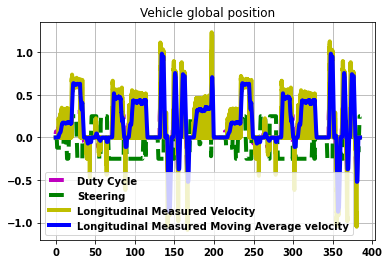

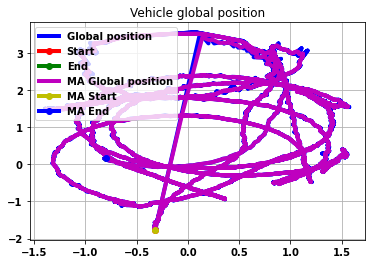

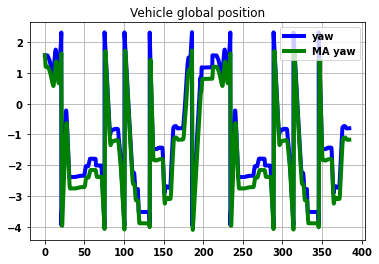

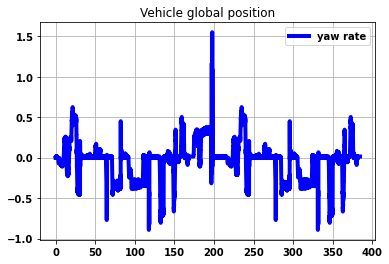

In [4]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

####################################################

start_index = 0 
end_index = 90000

valid_control = control_his_resistive_estimation['duty_cycle'][start_index:end_index]
valid_steer = control_his_resistive_estimation['steering'][start_index:end_index]

valid_vx = np.array(enc_his_resistive_estimation['vx'][start_index:end_index])
valid_X = np.array(fcam_his_resistive_estimation['X'][start_index:end_index])
valid_Y = np.array(fcam_his_resistive_estimation['Y'][start_index:end_index])
valid_w = np.array(imu_his_resistive_estimation['yaw_rate'][start_index:end_index]) 
valid_w -= np.mean(valid_w[:10])
valid_yaw = np.array(imu_his_resistive_estimation['yaw'][start_index:end_index])
valid_yaw = -valid_yaw + valid_yaw[0] + pi/2

valid_vx_MA = np.array(enc_MA_his_resistive_estimation['vx'][start_index:end_index])
valid_X_MA = np.array(fcam_MA_his_resistive_estimation['X'][start_index:end_index])
valid_Y_MA = np.array(fcam_MA_his_resistive_estimation['Y'][start_index:end_index])
valid_w_MA = np.array(imu_MA_his_resistive_estimation['yaw_rate'][start_index:end_index])
valid_w_MA -= np.mean(valid_w_MA[:10])
valid_yaw_MA = np.array(imu_MA_his_resistive_estimation['yaw'][start_index:end_index])
valid_yaw_MA = -valid_yaw_MA + valid_yaw_MA[0] + pi/2

valid_time = np.array(enc_his_resistive_estimation['timestamp_ms'][start_index:end_index])
valid_time = valid_time - valid_time[0]

####################################################

plt.figure()
plt.plot(valid_time,valid_control, '--m',label ='Duty Cycle',linewidth=4)
plt.plot(valid_time,valid_steer, '--g',label ='Steering',linewidth=4)
plt.plot(valid_time,valid_vx,'y',label = 'Longitudinal Measured Velocity',linewidth=4)
plt.plot(valid_time,valid_vx_MA,'b',label = 'Longitudinal Measured Moving Average velocity',linewidth=4)

plt.title('Vehicle global position')
plt.legend()
plt.grid()

####################################################

plt.figure()
plt.plot(valid_X,valid_Y,'b',label = 'Global position',linewidth=4)
plt.plot(valid_X[0],valid_Y[0],'-or',label = 'Start',linewidth=4)
plt.plot(valid_X[-1],valid_Y[-1],'-og',label = 'End',linewidth=4)

plt.plot(valid_X_MA,valid_Y_MA,'m',label = 'MA Global position',linewidth=4)
plt.plot(valid_X_MA[0],valid_Y_MA[0],'-oy',label = 'MA Start',linewidth=4)
plt.plot(valid_X_MA[-1],valid_Y_MA[-1],'-ob',label = 'MA End',linewidth=4)

plt.title('Vehicle global position')
plt.legend()
plt.grid()

####################################################

plt.figure()
plt.plot(valid_time,valid_yaw,'b',label = 'yaw',linewidth=4)
plt.plot(valid_time,valid_yaw_MA,'g',label = 'MA yaw',linewidth=4)

plt.title('Vehicle global position')
plt.legend()
plt.grid()

####################################################

plt.figure()
plt.plot(valid_time,valid_w,'b',label = 'yaw rate',linewidth=4)
# plt.plot(valid_time,valid_yaw_MA,'g',label = 'MA yaw',linewidth=4)

plt.title('Vehicle global position')
plt.legend()
plt.grid()

In [5]:
def LPV_model (vx,vy,omega,theta,delta):

    # Parameters
    m = 2.424
    rho = 1.225
    lr = 0.1203
    lf = 0.1377
    Cm0 = 10.1305
    Cm1 = 1.05294
    C0 = 3.68918
    C1 = 0.0306803
    Cd_A = -0.657645
    Caf = 1.3958
    Car = 1.6775
    Iz = 0.02

    F_flat = 0
    Fry = 0
    Frx = 0
    
    A31 = 0
    A11 = 0
    
    # eps = 0.0000001
    eps = 0
    if abs(vx)> 0:
        F_flat = 2*Caf*(delta- atan((vy+lf*omega)/(vx+eps)))
        Fry = -2*Car*atan((vy - lr*omega)/(vx+eps)) 
        A11 = -(1/m)*(C0 + C1/(vx+eps) + Cd_A*rho*vx/2)
        A31 = -Fry*lr/((vx+eps)*Iz)
        
    A12 = omega
    A21 = -omega
    A22 = 0
    
    if abs(vy) > 0.0:
        A22 = Fry/(m*(vy+eps))

    A41 = cos(theta)
    A42 = -sin(theta)
    A51 = sin(theta)
    A52 = cos(theta)


    B12 = 0
    B32 = 0
    B22 = 0
    
    if abs(delta) > 0:
        B12 = -F_flat*sin(delta)/(m*(delta+eps))
        B22 = F_flat*cos(delta)/(m*(delta+eps))    
        B32 = F_flat*cos(delta)*lf/(Iz*(delta+eps))

    B11 = (1/m)*(Cm0 - Cm1*vx)
    
    A = np.array([[A11, A12, 0,  0,   0,  0],\
                  [A21, A22, 0,  0,   0,  0],\
                  [A31,  0 , 0,  0,   0,  0],\
                  [A41, A42, 0,  0,   0,  0],\
                  [A51, A52, 0,  0,   0,  0],\
                  [ 0 ,  0 , 1,  0,   0,  0]])
    
    B = np.array([[B11, B12],\
                  [ 0,  B22],\
                  [ 0,  B32],\
                  [ 0 ,  0 ],\
                  [ 0 ,  0 ],\
                  [ 0 ,  0 ]])
    
    return A, B

In [6]:
def vehicle_model (vx,vy,theta,omega,delta,D):
    
    # Parameters
    m = 2.424
    rho = 1.225
    lr = 0.1203
    lf = 0.1377
    Cm0 = 10.1305
    Cm1 = 1.05294
    C0 = 3.68918
    C1 = 0.0306803
    Cd_A = -0.657645
    Caf = 1.3958
    Car = 1.6775
    Iz = 0.02
    
    dX = vx*cos(theta) - vy*sin(theta)
    dY = vx*sin(theta) + vy*cos(theta)
    dtheta = omega

    F_flat = 0
    Fry    = 0
    Frx    = (Cm0 - Cm1*vx)*D - C0*vx - C1 - (Cd_A*rho*vx**2)/2
    if abs(vx)>0:
        Fry = -2.0*Car*tan((vy - lr*omega)/vx) 
        F_flat = 2.0*Caf*(delta - tan((vy+lf*omega)/vx))

    ddotx = (1/m)*(Frx - F_flat*sin(delta) + m*vy*omega)

    ddoty = (1/m)*(F_flat*cos(delta) + Fry - m*vx*omega)

    ddottheta = (1.0/Iz)*(lf*F_flat*cos(delta) - lr*Fry)
    
    return np.array([ddotx, ddoty, ddottheta, dX,dY,dtheta,])


### Open loop simulation on TS model

In [8]:
valid_steer = np.array(valid_steer)
valid_control = np.array(valid_control)

deltap = valid_steer[0]
vxp = 0
betap = 0
vyp = 0
Xp = valid_X_MA[0]
Yp = valid_Y_MA[0]
omegap = 0
thetap = valid_yaw[0]

####################################################

statesp = np.array([vxp,vyp,omegap,Xp,Yp,thetap]).T

settings = {}

settings["nx"] = 6
settings["nu"] = 2
settings["lmbd"] = 0.9 # USELESS?
settings["effective_N"] = 200 # USELESS?
settings["thr_continuous_anomalies"] = 5
settings["separation"] = 0.1
settings["ff"] = 0.975
settings["nphi"] = 20

lpv_mpc_eefig = LPV_MPC_EEFIG(settings)

states_hisp =[]
states_hisp.append(statesp)

# Print Numpy Matrixes
np.set_printoptions(precision=3)

# PLOT
plot = PlotGranules()

for i in range(len(valid_time)-1):
    
    if valid_control[i] > 0.15:

        dt = valid_time[i+1] - valid_time[i]
        u = np.array([valid_control[i],valid_steer[i]]).T
        xk = np.hstack([statesp, u])

        # Open Loop LPV
        A_lpv, B_lpv = LPV_model(vxp,vyp,omegap,thetap,valid_steer[i])
        #print(A_lpv)
        #print(B_lpv)
        dstates = np.dot(A_lpv,statesp) + np.dot(B_lpv,u)

        # Open Loop LPV
        A, B = lpv_mpc_eefig.step(xk)
        #print(A)
        #print(B)
        #print("################################")
        dstates = np.dot(A,statesp) + np.dot(B,u)

        # Discrete Open Loop Simualation
        #dstates = vehicle_model(vxp,vyp,thetap,omegap,valid_steer[i],valid_control[i]) #non-linear model
        
        # Update Status
        statesp = statesp + dstates*dt

        # Plot Granules
        plot.save_xk(xk)
        #plot.save_granules(lpv_mpc_eefig.eefig)
        #plot.save_tracker(lpv_mpc_eefig.eefig)
    
    vxp = statesp[0]
    vyp = statesp[1]
    omegap = statesp[2]
    thetap = statesp[5]

    states_hisp.append(statesp)

states_hisp = np.array(states_hisp)

####################################################

plt.figure()

plt.plot(states_hisp[:,3],states_hisp[:,4])

plt.title('Vehicle global position')
plt.grid()
plt.show()

####################################################

plt.figure()

plt.plot(valid_time, valid_control, linewidth = 2,label = 'Duty cycle ')
plt.plot(valid_time, valid_steer, linewidth = 2,label = 'Steering')
plt.plot(valid_time, valid_vx_MA, linewidth = 2,label = 'real vx ')
plt.plot(valid_time, states_hisp[:,0], linewidth = 2,label = 'vx sim ')
# plt.plot(yaw_time_trun[:-1],  vy_hist, '-o', linewidth = 5, label = 'vy sim ')

plt.legend(loc = 'lower center')
plt.title('Vehicle global position')
plt.grid()
plt.show()

####################################################

plt.figure()

plt.plot(valid_time, states_hisp[:,2], linewidth = 2,label = 'Estimated omega')
plt.scatter(valid_time, valid_w_MA,label = 'Real omega ')
# plt.plot(valid_time, valid_w_MA, '--', linewidth = 2,label = 'Real omega ')

plt.title('Vehicle global position')
plt.legend(loc = 'lower center')
plt.grid()

####################################################

plt.figure()

plt.plot(valid_X_MA,valid_Y_MA,'g' ,linewidth = 2,label = 'Global position')
plt.plot(valid_X_MA[0],valid_Y_MA[0], '-or', linewidth = 5)
plt.plot(valid_X_MA[-1],valid_Y_MA[-1], '-*g', linewidth = 15)
plt.plot(np.mean(valid_X_MA),np.mean(valid_Y_MA), '-*g', linewidth = 15)
plt.plot(np.array(states_hisp[:,3]), states_hisp[:,4],'b',label = 'Estimated postion ')
plt.plot(states_hisp[:,3][0],states_hisp[:,4][0], '-or', linewidth = 5)
plt.plot(states_hisp[:,3][-1],states_hisp[:,4][-1], '-*g', linewidth = 15)

plt.title('Vehicle global position')
plt.grid()
plt.show()

####################################################

plt.figure()

plt.plot(valid_time,valid_Y_MA,'g' ,linewidth = 2,label = 'Global position')
plt.plot(valid_time, states_hisp[:,4],'b',label = 'Estimated postion ')

plt.title('Vehicle global position')
plt.grid()
plt.show()

####################################################

plt.figure()

plt.plot(valid_time,valid_X_MA,'g' ,linewidth = 2,label = 'Global position')
plt.plot(valid_time, states_hisp[:,3],'b',label = 'Estimated postion ')

plt.title('Vehicle global position')
plt.grid()
plt.show()

####################################################

plt.figure()
plt.plot(valid_time,valid_yaw,'g' ,linewidth = 2,label = 'Global position')
plt.plot(valid_time, states_hisp[:,5],'b',label = 'Estimated postion ')

plt.title('Vehicle global position')
plt.grid()
plt.show()

####################################################
       
plt.figure()
plt.plot(valid_time, states_hisp[:,1], linewidth = 2,label = 'vy')

plt.legend(loc = 'lower center')

plt.title('Vehicle global position')
plt.grid()
plt.show()

/home/felix/Desktop/ws_IRI/src/EEFIG_Learning/scripts/eefig_online.py:67: UserWarning: eefig_online.py: One granule had a zero size A matrix. We used WLS to solve this issue.
  warnings.warn("eefig_online.py: One granule had a zero size A matrix. We used WLS to solve this issue.")


KeyboardInterrupt: 

In [ ]:
anim = plot.plot(lpv_mpc_eefig.eefig)
HTML(anim.to_html5_video())